### Imports

In [520]:
import math
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import silhouette_score
from sklearn.metrics import adjusted_rand_score
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn")


### Distância de Minkowski

In [521]:
def calculateDist(p1, p2, n):
    return ((abs(p1[0] - p2[0])**n) + (abs(p1[1] - p2[1])**n)) ** (1/n)

* __Distância Manhattan__ __->__  n = 1

* __Distância Euclidiana__ __->__  n = 2


In [522]:
def calculateDistances(pontos, n):
    distances = [[] for _ in range(len(pontos))]
    for i, p1 in enumerate(pontos):
        for j, p2 in enumerate(pontos):
            distances[i].append(calculateDist(p1, p2, n))
    return distances

### Função para vizualização

Para pontos em duas dimensões

In [523]:
def plotClusters2D(clusters,n):
    
    plt.figure(figsize=(8, 8))
    colors = plt.get_cmap('Set1', len(clusters))  
    
    for i, cluster in enumerate(clusters):
        cluster_points = np.array(cluster)
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], color=colors(i), label=f'Cluster {i + 1}')
        
        #Centro do cluster
        center = np.array(cluster[0])
        plt.scatter(center[0], center[1], color='black', marker='x')
        
        #Raio
        max_dist = max([calculateDist(center,p,n) for p in cluster])
        circle = plt.Circle(center, max_dist, color=colors(i), fill=False, linestyle='--')
        plt.gca().add_patch(circle)
        plt.text(center[0], center[1] + max_dist + 0.3, f'Raio: {max_dist:.2f}', color=colors(i), ha='center')
    
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title(f'Clusters')
    plt.legend()
    plt.grid(True)
    plt.axis('equal')
    plt.show()


Para pontos em três dimensões

In [524]:
def plotClusters3D(clusters, n):
    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(111, projection='3d')
    colors = plt.get_cmap('tab20b', len(clusters))
    
    for i, cluster in enumerate(clusters):
        cluster_points = np.array(cluster)
        ax.scatter(cluster_points[:, 0], cluster_points[:, 1], cluster_points[:, 2], color=colors(i), label=f'Cluster {i + 1}')
        
        # Centro do cluster
        center = np.mean(cluster_points, axis=0)
        ax.scatter(center[0], center[1], center[2], color='black', marker='x')
        
        # Raio
        max_dist = max([calculateDist(center, p, n) for p in cluster])
        
        #Nesse caso temos uma esfera e não circulo
        u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
        x = max_dist * np.cos(u) * np.sin(v) + center[0]
        y = max_dist * np.sin(u) * np.sin(v) + center[1]
        z = max_dist * np.cos(v) + center[2]
        
        ax.plot_surface(x, y, z, color=colors(i), alpha=0.3, edgecolor='none')
        ax.text(center[0], center[1], center[2] + max_dist + 0.3, f'Raio: {max_dist:.2f}', color=colors(i), ha='center')
    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title('Clusters')
    ax.legend()
    plt.show()

Para várias dimensões a vizualização em gráficos fica inviável

In [525]:
def printClusters(clusters,n):
    
    print(f"Clusters encontrados: {len(clusters)}")
    for i, cluster in enumerate(clusters):
        print(f"Cluster {i + 1}:")
        print(f"Pontos: {cluster}")
        max_dist = max([calculateDist(cluster[0], p,2) for p in cluster])
        print(f"Raio do Cluster: {max_dist}")

Função auxiliar 

In [526]:
def get_labels(clusters, pontos):
    labels = [-1] * len(pontos)  # Initialize labels with -1 for safety
    point_to_label = {}

    # Create a mapping from each point to its cluster label
    for cluster_index, cluster in enumerate(clusters):
        for point in cluster:
            point_to_label[tuple(point)] = cluster_index

    # Assign labels to the original points based on the mapping
    for i, point in enumerate(pontos):
        labels[i] = point_to_label[tuple(point)]
        
    return labels

### Primeira versão do algoritmo 2-aproximado

Nessa versão  o intervalo para o raio ótimo é refinado até uma largura definida. Primeiramente vamos definir funções auxiliares para conseguir fazer o algoritmo:

In [527]:
#Função responsável por determinar se é possível dado um conjunto de pontos achar k clusters de raio maximo 2 rmax

def findSolution(pontos, rmax, k,n):
    success = False
    solution = []
    clusters = []
    pts = pontos[:]
    
    while len(pts) > 0:
        current_p = pts.pop(0)
        solution.append(current_p)
        cluster = [current_p]
        
        pts_to_remove = []
        for p in pts:
            if calculateDist(current_p, p, n) < 2 * rmax:
                cluster.append(p)
                pts_to_remove.append(p)
        
        for p in pts_to_remove:
            pts.remove(p)
        
        clusters.append(cluster)
    
    if len(solution) <= k:
        success = True
    
    return success, clusters


Agora podemos ir para a implementação do algoritmo em si:

In [528]:
def k_clustering(pontos,porcentagem_largura,k_clusters,n_distancia,distMatrix,true_labels):
    limite_superior = max(max(row) for row in distMatrix)
    limite_inferior = 0
    
    largura_total = limite_superior - limite_inferior 
    
    raio = limite_superior/2
    
    while (limite_superior-limite_inferior) >= (porcentagem_largura*largura_total):
        success, clusters = findSolution(pontos, raio, k_clusters,n_distancia)
        if success:
            limite_superior = raio
            raio = limite_superior/2
        else:
            limite_inferior = raio
            raio = raio + raio/2
            
    raios = [[] for _ in range(len(clusters))]
    for i, cluster in enumerate(clusters):
        center = cluster[0]
        max_dist = max([distMatrix[pontos.index(center)][pontos.index(p)] for p in cluster])
        raios[i].append(max_dist)
    
    labels = get_labels(clusters, pontos)
    sil_score = silhouette_score(pontos, labels)
    ari = adjusted_rand_score(true_labels, labels)
    
    return clusters, raios, sil_score, ari

### Segunda versão do algoritmo 2-aproximado

Nessa os centros são escolhidos para maximizar a distância entre os centros previamente escolhidos

In [529]:
#Calcula o ponto com a máxima distância mínima aos pontos em centers
def mostDistant(pontos, centers, n, distMatrix):
    maxDist = 0
    for p in pontos:
        if p not in centers:
            minDist = np.inf
            for c in centers:
                dist = distMatrix[pontos.index(p)][pontos.index(c)]
                if dist < minDist:
                    minDist = dist
            if minDist > maxDist:
                maxDist = minDist
                p_choice = p
    return p_choice

#Determina os centros dos clusters
def getCenters(pontos,k_clusters,n,distMatrix):
    if k_clusters >= len(pontos):
        return pontos
    
    centers = [pontos[0]]
    while (len(centers) < k_clusters):
        s = mostDistant(pontos, centers, n, distMatrix)
        centers.append(s)
    return centers

#Determina o centro mais próximo do ponto p
def find_closest_center(pontos, centers, p, n, distMatrix):
    minDist = np.inf
    for c in centers:
        dist = distMatrix[pontos.index(p)][pontos.index(c)]
        if dist < minDist:
            minDist = dist
            closest_center = c
    return closest_center

#Determina os clusters por meio da maximização dos centros já escolhidos
def makeClusters(pontos, k_clusters, n, distMatrix, true_labels):
    centers = getCenters(pontos, k_clusters, n, distMatrix)
    clusters = [[c] for c in centers] # inicializa os clusters apenas com o centro
    for p in pontos:
        closest_center = find_closest_center(pontos, centers, p, n, distMatrix)
        clusters[centers.index(closest_center)].append(p)
    # calcula o raio de cada cluster
    raios = [[] for _ in range(len(clusters))]
    for i, cluster in enumerate(clusters):
        center = cluster[0]
        max_dist = max([distMatrix[pontos.index(center)][pontos.index(p)] for p in cluster])
        raios[i].append(max_dist)

    labels = get_labels(clusters, pontos)
    sil_score = silhouette_score(pontos, labels)
    ari = adjusted_rand_score(true_labels, labels)
    
    return clusters, raios, sil_score, ari


### Kmeans

In [530]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score
import numpy as np

def performKmeans(pontos, true_labels, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    kmeans.fit(pontos)
    labels = kmeans.labels_
    centers = kmeans.cluster_centers_

    clusters = [[] for _ in range(n_clusters)]
    for i, label in enumerate(labels):
        clusters[label].append(pontos[i])

    for i in range(n_clusters):
        clusters[i] = np.array(clusters[i])
    
    sil_score = silhouette_score(pontos, labels)
    ari = adjusted_rand_score(true_labels, labels)

    radii = []
    centroids = kmeans.cluster_centers_
    for i in range(kmeans.n_clusters):
        # Get points in the cluster
        cluster_points = clusters[i]
        
        # Calculate distances from the centroid
        distances = np.linalg.norm(cluster_points - centroids[i], axis=1)
        
        # Get the maximum distance as the radius
        radius = np.max(distances)
        radii.append(radius)

    return clusters, radii, sil_score, ari


# Testes

### Geração de datasets sintéticos

##### Normal multivariada

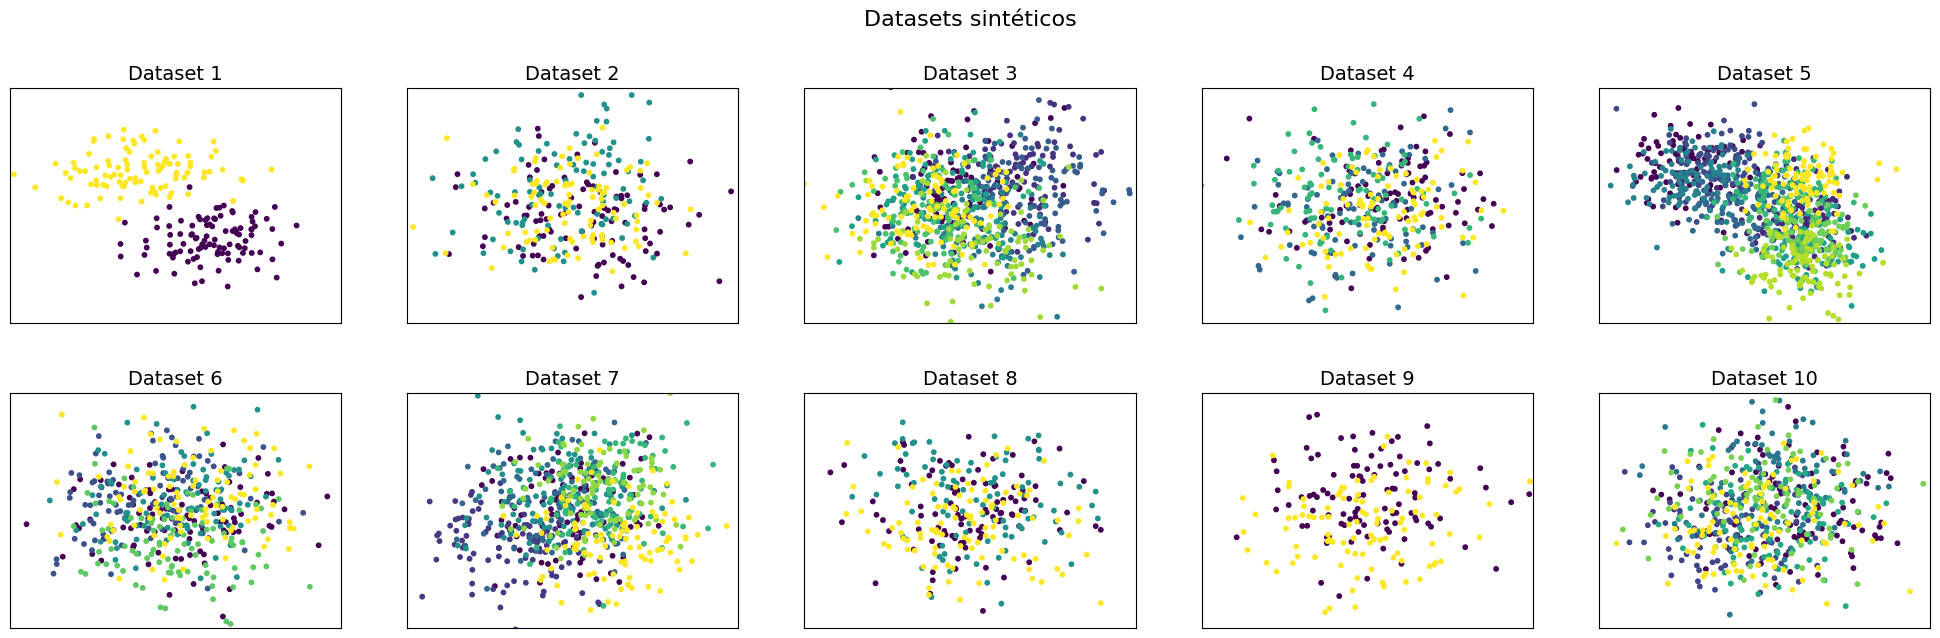

In [531]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

def generate_random_coordinates(x):
    coordinates = np.random.rand(x, 2)
    return coordinates

def generateSyntheticDataWithLabels(centers, std_dev, num_points_per_center):
    pontos = []
    labels = []
    
    for idx, center in enumerate(centers):
        cov_matrix = [[std_dev**2, 0], [0, std_dev**2]]
        points = np.random.multivariate_normal(mean=center, cov=cov_matrix, size=num_points_per_center)
        pontos.append(points)
        labels.extend([idx] * num_points_per_center)  # Assign label idx to each point
    
    return np.vstack(pontos), np.array(labels)

def apply_standard_scaling(data):
    scaler = StandardScaler()
    return scaler.fit_transform(data)

# Parameters for synthetic data generation
n_clusters = [2, 3, 8, 4, 10, 5, 7, 3, 2, 6]  # Número de clusters variado
std_devs = [0.1, 0.5, 0.3, 1.0, 0.2, 0.7, 0.4, 1.5, 0.6, 0.9]  # Desvios padrão variáveis

base_num_points = 100
num_points_per_center = [int(base_num_points) for std_dev in std_devs]

data = []
labels_list = []
for i in range(10):
    centers = generate_random_coordinates(n_clusters[i])
    dataset, labels = generateSyntheticDataWithLabels(centers, std_devs[i], num_points_per_center[i])
    scaled_dataset = apply_standard_scaling(dataset)
    data.append(scaled_dataset)
    labels_list.append(labels)

# Plotting
n_rows = 2
n_cols = 5
plt.figure(figsize=(4 * n_cols, 3 * n_rows))
plt.subplots_adjust(left=0.02, right=0.98, bottom=0.02, top=0.92, wspace=0.2, hspace=0.3)

for i in range(10):
    plt.subplot(n_rows, n_cols, i+1)
    plt.title(f"Dataset {i+1}", size=14)
    plt.scatter(data[i][:, 0], data[i][:, 1], c=labels_list[i], s=10, cmap='viridis')
    plt.xlim(-3, 3)
    plt.ylim(-3, 3)
    plt.xticks(())
    plt.yticks(())

plt.suptitle("Datasets sintéticos", size=16, y=1.05)
plt.show()

In [532]:
from datetime import datetime

# executa os 3 e retorna o tempo de execução, raio, silhueta e índice de rand ajustado
def executeAll(data, percentage, k_clusters, n_distance, labels):
    pontos = data.tolist()
    distMatrix = calculateDistances(pontos, n_distance)

    execution_info = []

    start_time = datetime.now()
    clusters_1, raios_1, sil_1, r_1 = k_clustering(pontos, percentage, k_clusters, n_distance, distMatrix, labels) # algortimo 1
    end_time = datetime.now()
    duration = end_time - start_time
    execution_info.append([duration, raios_1, sil_1, r_1])

    start_time = datetime.now()
    clusters_2, raios_2, sil_2, r_2 = makeClusters(pontos, k_clusters, n_distance, distMatrix, labels) # algortimo 2
    end_time = datetime.now()
    duration = end_time - start_time
    execution_info.append([duration, raios_2, sil_2, r_2])

    start_time = datetime.now()
    clusters_kmeans, raios_kmeans, sil_kmeans, r_kmeans = performKmeans(pontos, labels, k_clusters) # kmeans
    end_time = datetime.now()
    duration = end_time - start_time
    execution_info.append([duration, raios_kmeans, sil_kmeans, r_kmeans])

    return execution_info 

In [533]:
# pra cada teste, chamar essa função, que retorna a lista com duração, raio, silhueta e índice de rand ajustado
executeAll(data[0], 0.25, 3, 2, labels_list[0]) # teste da execução 

[[datetime.timedelta(microseconds=23334),
  [[1.3533958562193362],
   [1.2613439244499438],
   [1.1740382429205498],
   [1.3488565752060855],
   [1.238574084086904],
   [0.3067983655420312],
   [0.0]],
  0.2114308022276446,
  0.573739093208756],
 [datetime.timedelta(microseconds=7691),
  [[2.2186363994356384], [2.216703691967218], [1.831008154919553]],
  0.42797470837359247,
  0.7396097565413313],
 [datetime.timedelta(microseconds=31724),
  [1.6878233053905167, 1.7160666935610172, 1.6381000641027441],
  0.441734483666545,
  0.6901391569869025]]

##### Exemplos scikit learn

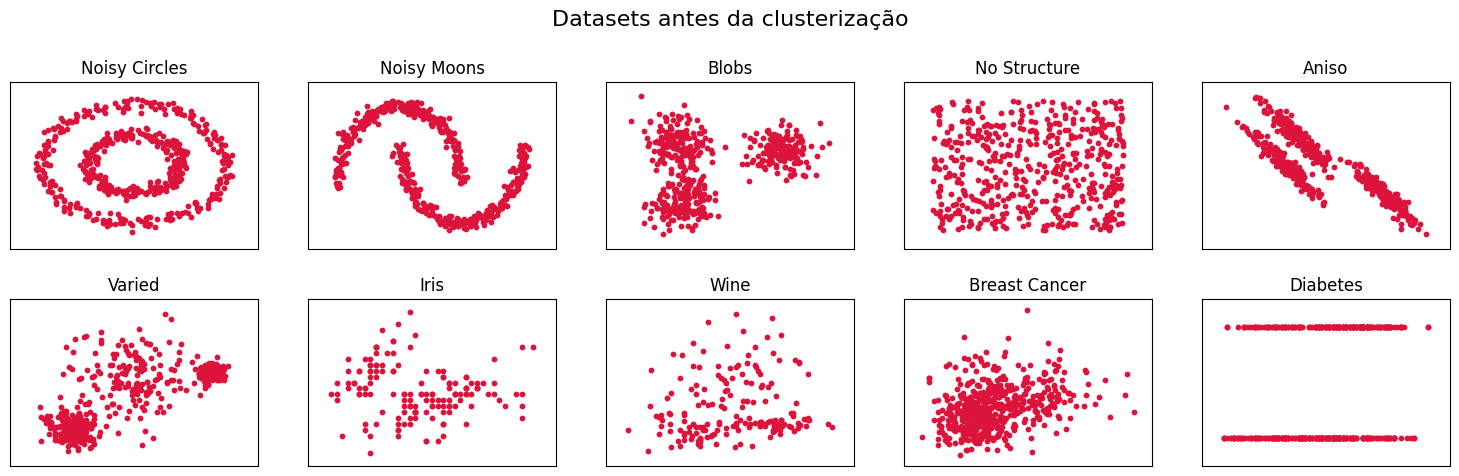

In [535]:
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
import numpy as np

# Load original datasets
noisy_circles = datasets.make_circles(n_samples=500, factor=0.5, noise=0.05, random_state=30)
noisy_moons = datasets.make_moons(n_samples=500, noise=0.05, random_state=30)
blobs = datasets.make_blobs(n_samples=500, random_state=30)
rng = np.random.RandomState(30)
no_structure = rng.rand(500, 2), None

# Anisotropicly distributed data
X, y = datasets.make_blobs(n_samples=500, random_state=170)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# Blobs with varied variances
varied = datasets.make_blobs(n_samples=500, cluster_std=[1.0, 2.5, 0.5], random_state=170)

# Load new datasets
iris = datasets.load_iris(return_X_y=True)
wine = datasets.load_wine(return_X_y=True)
breast_cancer = datasets.load_breast_cancer(return_X_y=True)
diabetes = datasets.load_diabetes(return_X_y=True)

# List of datasets and titles
datasets_list = [
    noisy_circles, noisy_moons, blobs, no_structure,
    aniso, varied, iris, wine, breast_cancer, diabetes
]
dataset_titles = [
    'Noisy Circles', 'Noisy Moons', 'Blobs', 'No Structure',
    'Aniso', 'Varied', 'Iris', 'Wine', 'Breast Cancer', 'Diabetes'
]

# Plot settings
n_cols = 5
n_rows = 2
fig_size = (4 * n_cols * 0.8, 3 * n_rows * 0.8)
plt.figure(figsize=fig_size)
plt.subplots_adjust(
    left=0.05, right=0.95, bottom=0.05, top=0.85, wspace=0.2, hspace=0.3
)

plt.suptitle('Datasets antes da clusterização', size=16, y=1.0)

for i, (dataset, title) in enumerate(zip(datasets_list, dataset_titles)):
    if len(dataset) == 2:
        X, _ = dataset  # For datasets that return X and y
    else:
        X, _ = dataset
    X = StandardScaler().fit_transform(X)
    
    plt.subplot(n_rows, n_cols, i + 1)
    plt.title(title, size=12)
    
    plt.scatter(X[:, 0], X[:, 1], s=10, color="crimson")
    plt.xlim(X[:, 0].min() - 0.5, X[:, 0].max() + 0.5)
    plt.ylim(X[:, 1].min() - 0.5, X[:, 1].max() + 0.5)
    plt.xticks(())
    plt.yticks(())

plt.show()
